NAME:  {TODO: Insert name here}
====

CSCE 823 Assginment 1 
---

Starter Code

Simple perceptron learning for NOT, OR, AND, and paper example (NUT).  Also trained on XOR which is
mainly a teaching tool to show how non-linearly separable points cannot be trained to with one layer.

In steps 4-7, Student will need to **analyze results and discuss** NOT, OR, AND and  NUT performance

In step 8, Student will need to analyze results and discuss performance of single layer perceptron XOR

In step 9, Student will need to build new multi layer perceptron for XOR, train, evaluate, and discuss performance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks


from sklearn.preprocessing import LabelEncoder

# import keras as keras

In [3]:
print("Tensor_Flow version:")
print(tf.__version__)

Tensor_Flow version:
2.6.0


In [4]:
print("Keras version:")
print(keras.__version__)

Keras version:
2.6.0


## Confirm tensorflow working properly
This will report on the GPUs available to tensorflow

In [5]:
print("Tensorflow version: ", tf.__version__)
print("Tensorflow devices: ", tf.config.list_physical_devices("GPU"))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
Tensorflow devices:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Enable GPU growth to solve cublas problem

(see https://stackoverflow.com/questions/41117740/tensorflow-crashes-with-cublas-status-alloc-failed)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Test Tensorflow to ensure it is ready to train a model on GPU

(runs 2 epochs of a CNN on cifar10... not necessary for this HW but helpful code to ensure trainability of CNN on GPU)

In [7]:
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images / 255.0, test_images / 255.0

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='Adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

history = model.fit(train_images, train_labels, batch_size=10, epochs=2)

Epoch 1/2
5000/5000 [==============================] - 13s 2ms/step - loss: 1.4460
Epoch 2/2
5000/5000 [==============================] - 12s 2ms/step - loss: 1.1599


# Step 0: Tools & Helper Functions

In [8]:
def makeDecisionBoundaryBool2(model,featureData,labelData,title):
    '''Build decision boundary figrue for 2-input, 1-output boolean logic functions
    Note that this assumes a hard sigmoid was used and establishes a cutoff at 0.5
    for predicting 0 or 1'''  
    cutoff = 0.5   #0.5 for Sigmoid. 0.0 for TANH
    fig, ax = plt.subplots()

    xmin,xmax = np.min(featureData[:,0])-0.1, np.max(featureData[:,0])+0.1
    ymin,ymax = np.min(featureData[:,1])-0.1, np.max(featureData[:,1])+0.1
    
    #Create filled countour map to color both sides of the boundary
    x = np.linspace(xmin,xmax,200)
    y = np.linspace(ymin,ymax,200)
    X, Y = np.meshgrid(x, y)
    grid = np.c_[X.ravel(),Y.ravel()]
    preds = model.predict(grid)  #get predictions
    z = preds.reshape(X.shape)>cutoff   # cutoff on predictions to return boolean output
    plt.contourf(X,Y,z,cmap='YlOrBr')
    
    #add annotated points to show where the boolean inputs lie on the graph
    ax.scatter(featureData[:,0],featureData[:,1], color='b', alpha = 0.5)
    for i, txt in enumerate(labelData):
        # ax.annotate(np.asscalar(txt), (featureData[i,0],featureData[i,1])) 
        ax.annotate(txt.item(), (featureData[i,0],featureData[i,1])) 
    
    #adjust the axis & add labels for the graph
    plt.axis([xmin, xmax, ymin, ymax])
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title(title)  

def graphHistory(history, title):
    '''Function for graphing the training and valiedation accuracy and loss'''
    # summarize history for accuracy
    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Tr. Acc', 'Val. Acc'])
    plt.show()

    # summarize history for loss
    fig = plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss ' + title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Tr. Loss', 'Val. Loss'])
    plt.show()
    

# Step 1: Generic Keras model for perceptron (must be parameterized on call)

In [9]:
def perceptron(width, learningRate):
    '''Builds and returns a perceptron model of arbitrary input width & learning rate'''
    model = models.Sequential()  #define the building mode - sequential
    # declare the hidden layer with 1 node, hard sigmoid
    # set bias vector to all 1s
    model.add(Dense(units=1, activation='hard_sigmoid', 
                    use_bias=True, bias_initializer='ones', 
                    input_shape=(width,)))
    # declare the adam optimizer
    adam = optimizers.Adam(learning_rate=learningRate)
    # complile the model with loss = binary_crossentropy
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Step 2:  Boolean Datasets

In [10]:
# Inputs to the perceptrons
xONE = np.array([[1],[0]])
xTWO = np.array([[0,0],[0,1],[1,0],[1,1]])
    
# y matrices for boolean output
yNOT = np.matrix('0;1')
yAND = np.matrix('0;0;0;1')
yOR = np.matrix('0;1;1;1')
yXOR = np.matrix('0;1;1;0')

# Step 3:  Instantiate Fyfe's Nut Dataset

In [11]:
# Defining NUT database arrays
xNUT = np.array([[2.2,1.4],[1.5,1.0],[0.6,0.5],[2.3,2.0],[1.3,1.5],[0.3,1.0]])
yNUT = np.array([[0],[0],[0],[1],[1],[1]])

# Step 4:  Modeling the Boolean NOT Dataset

## Step 4a:  Fit model on NOT dataset

In [12]:
# Learning 'NOT'

pmNOT = perceptron(width=1,learningRate=0.1)
training_verbosity = 0 #set to 1 or 2 for more detaied training output, 0 for none

history = pmNOT.fit(x=xONE, y=yNOT, batch_size=1, epochs=100, verbose=training_verbosity, callbacks=None, 
                      validation_split=0.0, 
                      validation_data=(xONE,yNOT), shuffle=True, class_weight=None,sample_weight=None, initial_epoch=0)




## Step 4b:  Report Training and Validation Performance Results

1/1 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
[0.0, 1.0]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


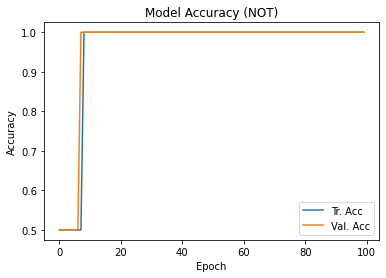

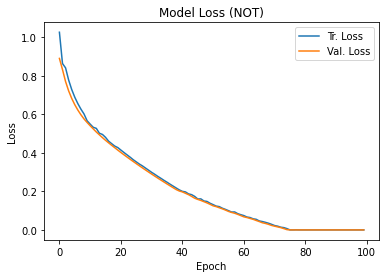

In [13]:
lossValMetrics = pmNOT.evaluate(xONE, yNOT, batch_size=2, verbose=2, sample_weight=None)
print(lossValMetrics)
#plot history
print(history.history.keys())    
graphHistory(history, '(NOT)')

## STUDENT TODO:  insert model performance discussion here.  You should experiment with different learning rate, and max epochs}

# Step 5: Modeling the  OR Dataset

## Step 5a:  Fit Model on OR
note that we are going to break the rule about train-val split because there are only 4 datapoints in this dataset and we need them all

We will use the same set for training and validation

In [14]:
# Learning OR
pmOR = perceptron(width=2,learningRate=0.1)
training_verbosity = 0 #set to 1 or 2 for more detaied training output, 0 for none
history = pmOR.fit(x=xTWO, y=yOR, batch_size=1, epochs=100, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xTWO,yOR), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

## Step 5b:  Evaluate training performance on OR

1/1 - 0s - loss: 0.0000e+00 - accuracy: 1.0000
[0.0, 1.0]
[array([[5.321106 ],
       [5.3383203]], dtype=float32), array([-2.5376816], dtype=float32)]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


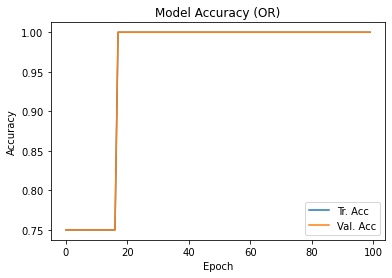

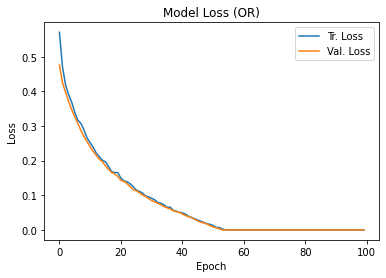

In [15]:
lossValMetrics = pmOR.evaluate(xTWO, yOR, batch_size=4, verbose=2, sample_weight=None)
print(lossValMetrics)
weights = pmOR.get_weights()
print(weights)
#plot history
print(history.history.keys())    
graphHistory(history, '(OR)')

{TODO:  insert model performance discussion here.  You should experiment with different learning rate, and max epochs}

## Step 5c:  Display the Decision Boundary on OR

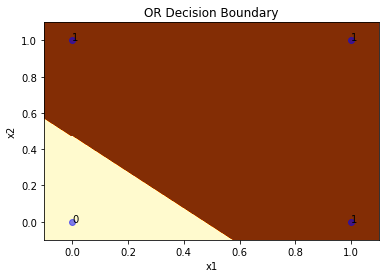

In [16]:
makeDecisionBoundaryBool2(pmOR,xTWO,yOR,'OR Decision Boundary')

{TODO:  insert discussion on the decision boundary and the relationship with the weights of the model.  }

# Step 6:  Modeling the AND Dataset

## Step 6a:  Fit model to AND Dataset
note that we are going to break the rule about train-val split because there are only 4 datapoints in this dataset and we need them all

We will use the same set for training and validation

In [17]:
pmAND = perceptron(width=2,learningRate=0.01)
training_verbosity = 0 #set to 1 or 2 for more detaied training output, 0 for none
history = pmAND.fit(x=xTWO, y=yAND, batch_size=1, epochs=500, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xTWO,yAND), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

## Step 6b:  Evaluate Training Performance on AND Dataset

1/1 - 0s - loss: 0.2413 - accuracy: 1.0000
[0.24132338166236877, 1.0]
[array([[2.0104265],
       [1.948041 ]], dtype=float32), array([-3.4721255], dtype=float32)]


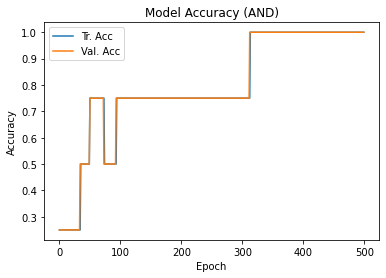

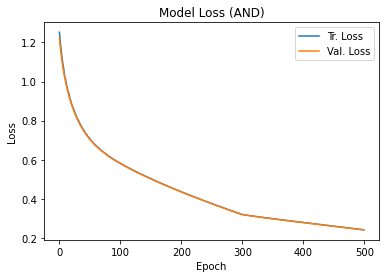

In [18]:
lossValMetrics = pmAND.evaluate(xTWO, yAND, batch_size=4, verbose=2, sample_weight=None)
print(lossValMetrics)
weights = pmAND.get_weights()
print(weights)
graphHistory(history, '(AND)')

## Step 6c:  Display Decision Boundary of AND Dataset

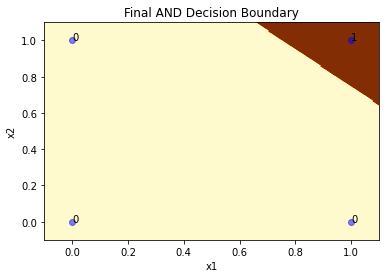

In [19]:
makeDecisionBoundaryBool2(pmAND,xTWO,yAND,'Final AND Decision Boundary')

{TODO - Describe Decision Boundary on AND Dataset}

# Step 7:  Modeling Fyfe's NUT dataset

## Step 7a:  Fit a perceptron model to the NUT dataset
note that we are going to break the rule about train-val split because there are only 4 datapoints in this dataset and we need them all

We will use the same set for training and validation

In [20]:
# Final learning scenario -- NUT
#batchSize, width, learningRate
pmNUT = perceptron(width=2,learningRate=0.1)
training_verbosity = 0 #set to 1 or 2 for more detaied training output, 0 for none
history = pmNUT.fit(x=xNUT, y=yNUT, batch_size=1, epochs=100, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xNUT,yNUT), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

In [21]:
## Step 7b:  Evaluate model performance on the NUT dataset

1/1 - 0s - loss: 0.3191 - accuracy: 1.0000
[0.3191290497779846, 1.0]
[array([[-2.1132855],
       [ 3.7415893]], dtype=float32), array([-1.5998242], dtype=float32)]


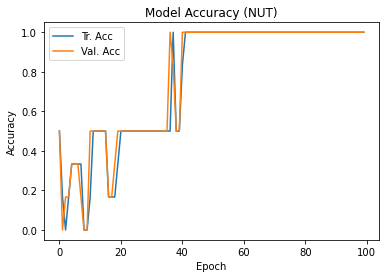

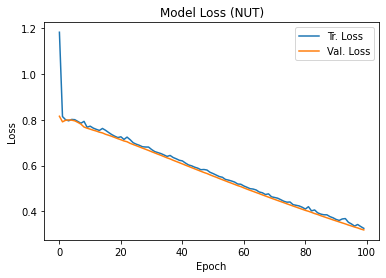

In [22]:
lossValMetrics = pmNUT.evaluate(xNUT, yNUT, batch_size=6, verbose=2, sample_weight=None)
print(lossValMetrics)
print(pmNUT.get_weights())
graphHistory(history, '(NUT)')

## Step 7c:  Plot decision boundary on NUT dataset

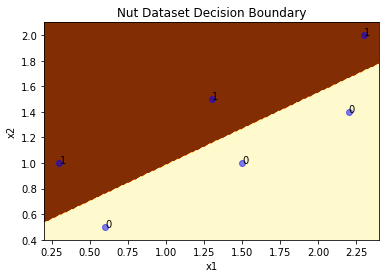

In [23]:
makeDecisionBoundaryBool2(pmNUT,xNUT,yNUT,'Nut Dataset Decision Boundary')

{TODO:  add discussion}

# Step 8: Modeling XOR logic with a single perceptron

## Step 8a:  Fit a single perceptron to the XOR data
note that we are going to break the rule about train-val split because there are only 4 datapoints in this dataset and we need them all

We will use the same set for training and validation

In [24]:
# This will not perform well due to the classes are not linearly seperable
print("Starting XOR training")
#batchSize, width, learningRate
pm_single_layerXOR = perceptron(width=2,learningRate=.1)
training_verbosity = 0 #set to 1 or 2 for more detaied training output, 0 for none
history = pm_single_layerXOR.fit(x=xTWO, y=yXOR, batch_size=1, epochs=200, verbose=training_verbosity, callbacks=None, 
    validation_split=0.0, validation_data=(xTWO,yXOR), shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)
print("Completed XOR training")

Starting XOR training
Completed XOR training


## Step 8b:  Evaluate single perceptron model performance on the XOR data

1/1 - 0s - loss: 3.8123 - accuracy: 0.7500
[3.812309503555298, 0.75]
[array([[5.4560347],
       [5.3254123]], dtype=float32), array([-2.6556752], dtype=float32)]


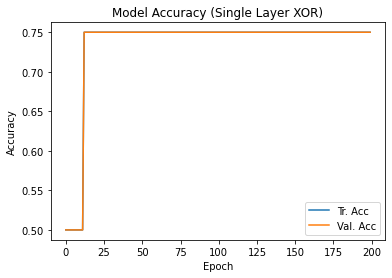

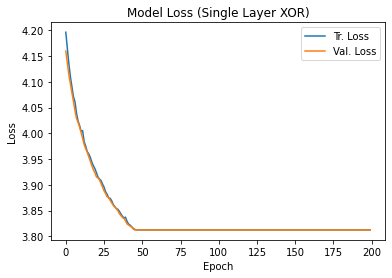

In [25]:
lossValMetrics = pm_single_layerXOR.evaluate(xTWO, yXOR, batch_size=4, verbose=2, sample_weight=None)
print(lossValMetrics)
print(pm_single_layerXOR.get_weights())
graphHistory(history, '(Single Layer XOR)')

## Step 8c:  Decision Boundary for XOR using single perceptron

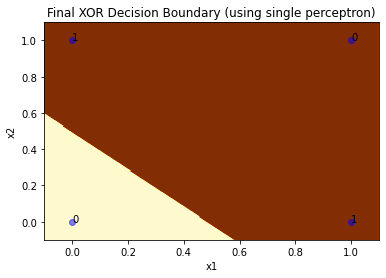

In [26]:
makeDecisionBoundaryBool2(pm_single_layerXOR,xTWO,yXOR,'Final XOR Decision Boundary (using single perceptron)')

# Step 9:  Modeling XOR with a Multilayer Perceptron

## Step 9a:  Define your multilayer models in Keras

{TODO: discussion of how you built the model & selected ranges of parameter choices}

In [27]:
#TODO - insert student code here
# your model should be called "pm_multi_layerXOR"

 

## Step 9b:  Fit the models on the XOR dataset

In [28]:
#TODO - insert student code here


## Step 9c:  Report the performances of the multilayer models on XOR

In [29]:
#TODO - insert Student code here


{TODO:  insert discussion here}

## Step 9d:  Plot the decision boundary for the best multilayer perceptron on XOR

In [30]:
#uncomment the following line after you build & train your model
#makeDecisionBoundaryBool2(pm_multi_layerXOR,xTWO,yXOR,'Final XOR Decision Boundary (using multilayer perceptron)')

{TODO:  insert discussion here}